In [1]:
from scipy.stats import kurtosis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
my_random_state = 318
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, normalize
from sklearn.metrics import accuracy_score,plot_confusion_matrix, confusion_matrix


from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.random_projection import GaussianRandomProjection as RP

clusterings = ['KMeans','EM']
dimReductions = ['PCA','ICA', 'RP', 'IG']

In [2]:
###### E-coli 
### http://archive.ics.uci.edu/ml/datasets/Ecoli
# data = pd.read_csv('datafiles/ecoli.csv')))  # very unbalanced
# class_names = np.array(['cp', 'im', 'imL', 'imS', 'imU','om','omL','pp'])
data = pd.read_csv('datafiles/ecoli-balance.csv') # balanced: merged sub-species of E-coli
class_names = np.array(['cp', 'im', 'om','pp'])
y_data = data.Y
x_data = data.loc[:,'X1':'X7']


one_hot = OneHotEncoder()
y_data_hot = one_hot.fit_transform(y_data.values.reshape(-1, 1)).todense()
# y_test_hot = le.transform(y_test.reshape(-1, 1)).todense()
y_data_hot.shape


le = LabelEncoder()
le.fit(y_data.values.tolist())
y_data_le = le.transform(y_data)
y_data_le.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_le, train_size=0.7, random_state=my_random_state, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(235, 7) (101, 7) (235,) (101,)


In [70]:
thisDR = 'noDR'
x_train_transform = x_train
x_test_transform = x_test

# PCA

In [74]:
# 4 component is best (beyond elbow & cum var > 0.9)
thisDR = 'PCA'
best_n_components = 4
bestDR = PCA(n_components=best_n_components)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)

# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.002285813672259965 for n=4

n_km = 3
n_gm = 3

MSE:  0.008370548519702078


# ICA

In [53]:
thisDR = 'ICA'
# 6 component is best (max kurtosis)
best_n_components = 6
bestDR = FastICA(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)


# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.02573452901766932 for n=6

n_km = 6
n_gm = 4

MSE:  0.02573452901766932


# RP

In [66]:
thisDR = 'RP'
# 5 component is best (relatively min MSE)
best_n_components = 5
bestDR = RP(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)

x_train_inverse = np.linalg.pinv(bestDR.components_.T)
x_train_reconstruct = x_train_transform.dot(x_train_inverse)
# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_reconstruct))/x_train_reconstruct.size
print('MSE: ', mse)
#  MSE:  0.04266261920459053 for n=5

n_km = 5
n_gm = 5

MSE:  0.04266261920459053


# NMF

In [78]:
thisDR = 'NMF'
best_n_components = 7
bestDR = NMF(n_components=best_n_components, random_state = my_random_state)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)

# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)

n_km = 3
n_gm = 3

MSE:  0.03859561535342077


# KMeans!!  KMeans

In [54]:
thisClust = 'KMeans'
km = KMeans(n_clusters = n_km, random_state = my_random_state)


tic = time.perf_counter() 
km.fit(x_train_transform) ##########
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

print(km.cluster_centers_)
print(km.labels_)
print(km.inertia_)
print(km.n_iter_)

x_train_clust = km.transform(x_train_transform)
x_test_clust = km.transform(x_test_transform)
x_test_clust.shape

training time 0.033887699999922916 seconds

[[-0.04867956 -0.03894774 -0.02245866 -0.01193041 -0.01368001 -0.01648122]
 [ 0.06118898 -0.05605122  0.07842398 -0.01134342 -0.00151801 -0.01073095]
 [ 0.02092028  0.08172135 -0.01073043 -0.01310359 -0.01115916 -0.01046734]
 [-0.00129326  0.00467521 -0.00041469  0.3470078  -0.00569945  0.00675564]
 [ 0.04586344 -0.02627066 -0.0026901  -0.01409319  0.01405355  0.16131605]
 [-0.00475794  0.01993939  0.00276263 -0.00724024  0.2785302  -0.01464345]]
[0 0 1 2 2 0 1 0 2 3 0 2 1 2 2 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 4 2 1 2 3 3 0
 1 4 1 1 1 5 2 2 0 4 5 1 0 0 0 2 2 0 0 2 2 0 0 1 5 2 2 1 1 0 4 4 0 3 0 0 0
 1 2 4 1 0 0 3 0 0 0 0 1 0 0 1 2 0 0 1 0 0 1 2 2 0 1 2 0 2 4 2 0 2 1 0 2 2
 1 0 0 4 2 0 2 1 1 0 2 1 2 0 4 0 2 1 2 4 2 4 0 2 0 2 3 0 2 0 1 0 0 2 2 2 2
 0 2 1 0 0 5 0 0 0 4 2 3 2 5 0 0 2 1 4 0 0 4 0 1 0 1 2 0 2 2 2 1 2 2 0 0 2
 2 1 2 4 0 0 0 0 0 3 0 0 2 2 0 2 1 2 2 0 2 0 2 1 0 4 0 2 2 1 1 2 2 0 0 2 2
 5 2 4 0 2 2 0 0 1 5 2 0 0]
2.4780053936314106
7


(101, 6)

# Expectation Maximization!!! Gaussian Mixture!!!

In [79]:
thisClust = 'GaussMix'
gm = GaussianMixture(n_components = n_gm, random_state = my_random_state)


tic = time.perf_counter() 
gm.fit(x_train_transform) ##########
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

# print(km.cluster_centers_)
# print(km.labels_)
# print(km.inertia_)
# print(km.n_iter_)

x_train_clust = gm.predict_proba(x_train_transform)
x_test_clust = gm.predict_proba(x_test_transform)
x_test_clust.shape

training time 0.010874100000364706 seconds



(101, 3)

# run NN

In [80]:
############## using GridSearch
nn3layer = MLPClassifier(random_state=my_random_state, hidden_layer_sizes = (20,20,20))
alpha_range = np.logspace(-4, 3, 8)
learningrate_range = np.logspace(-4, 1, 6)
parameters = {'alpha':alpha_range, 'learning_rate_init': learningrate_range}
grid_nn = GridSearchCV(nn3layer, parameters)

tic = time.perf_counter() 
# grid_nn.fit(x_train_transform, y_train)
grid_nn.fit(x_train_clust, y_train)
toc = time.perf_counter() 
print(f"training time for {thisDR} - {thisClust} is {toc - tic} seconds")
print()

print(f"{thisDR} - {thisClust}: best parameters & score from GridSearchCV: ")
print(grid_nn.best_params_)
print(grid_nn.best_score_)
print()

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

training time for NMF - GaussMix is 25.14617509999971 seconds

NMF - GaussMix: best parameters & score from GridSearchCV: 
{'alpha': 0.01, 'learning_rate_init': 0.1}
0.4212765957446809



NMF - GaussMix: Prediction accuracy on train set: 
0.425531914893617

testing time for NMF - GaussMix is 0.0007190000005721231 seconds
NMF - GaussMix: Prediction accuracy on test set: 
0.33663366336633666


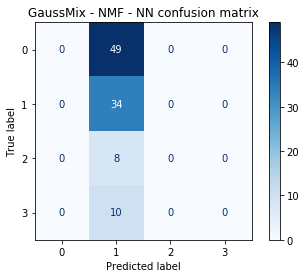

In [81]:

# y_train_nn = grid_nn.predict(x_train_transform)
y_train_nn = grid_nn.predict(x_train_clust)
print(f"{thisDR} - {thisClust}: Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_nn))
print()

tic = time.perf_counter() 
y_test_nn = grid_nn.predict(x_test_clust)
toc = time.perf_counter() 
print(f"testing time for {thisDR} - {thisClust} is {toc - tic} seconds")
print(f"{thisDR} - {thisClust}: Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_nn))



# plot_confusion_matrix(grid_nn, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
# plt.savefig(f'NN/nn_{thisDR}_confusion_matrix_normalized.png') 
# plt.show()

plot_confusion_matrix(grid_nn, x_test_clust, y_test,cmap=plt.cm.Blues)
plt.title(f'{thisClust} - {thisDR} - NN confusion matrix')
plt.savefig(f'NN/nn_{thisClust}_{thisDR}_confusion.png') 
plt.show()